# Custom Losses and Metrics in Keras

Source of this notebook: https://www.tensorflow.org/tutorials/keras/regression

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

2022-11-01 11:36:27.113015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 11:36:27.243662: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-01 11:36:27.250509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 11:36:27.250534: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

##### Download the Auto-MPG Dataset

The goal of this task is to predict the fuel efficiency (Mileage per Gallon, MPG) of late-1970s and early 1980s cars. The input data for each car includes attributes like: cylinders, displacement, horsepower, weight, etc.

This dataset is not included in the `keras.datasets` so we will import it from a CSV file using `pandas` instead.

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

Let's make a copy of the dataset (to keep the original untouched) and see the first rows:

In [4]:
dataset = raw_dataset.copy()
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Some basic preprocessing: eliminate rows with missing values (complete case), and convert the categorical `Origin` column to the corresponding geographic area string. Finally, convert this categorical column to a one-hot representation using the `get_dummies` method:

In [5]:
dataset = dataset.dropna()
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


`get_dummies` transforms categorical values in one-hot encoding columns (in this case the `Origin` column)

In [6]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


Create train and test subsets:

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Split features from labels (the `pop()` method removes a column and creates a copy at the same time):

In [8]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# With pop method we discard a column we don't need
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

train_features.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0
182,4,107.0,86.0,2464.0,15.5,76,1,0,0


##### Build a simple model

We will approach the task with a simple linear model, built with the Sequential API. Before the single `Dense` layer, however, we will add a `Normalization()` layer, which normalizes each feature column to have 0 mean and unitary standard deviation.

We instantiate the normalization layer outside of the `Sequential()` call, because we need to `adapt()` it to the input features statistics:

In [9]:
normalizer = preprocessing.Normalization()

# convert the pandas df to a tensor-like numpy array before calling adapt or any TF method
normalizer.adapt(np.array(train_features))

2022-11-01 11:36:34.469656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-01 11:36:34.469712: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-01 11:36:34.469732: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-7817b2ad-42a3-441f-8072-b020be286d3c): /proc/driver/nvidia/version does not exist
2022-11-01 11:36:34.478965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Then, we build a sequential model with a single linear layer. We can also use a multi-layer NN if we want.

In [10]:
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(1)
])

model.summary()
keras.utils.plot_model(model, 'mpg_regression.png', show_shapes=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


##### Define a custom loss function

Let us define a custom loss function that we want to use to train this model. Here, we just re-define the Mean Squared Error (MSE), which of course is already present in `keras.losses`. However, in general, this is useful when you need to use task-specific or complex losses that are not already available.

Clearly, since the derivative of the loss function must be computed by Keras automatically during training, we need to make sure that our custom definition only uses TensorFlow ops (or overloaded operators).

In [11]:
def my_mse(y, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y))

Then, we can simply pass our custom `my_mse` loss to the compile function:

In [12]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss=my_mse, metrics=['mae', 'mse'])

... and train the model, normally:

In [13]:
history = model.fit(
    train_features, train_labels,
    epochs=40,
    validation_split = 0.2,
    validation_freq=1
)

Epoch 1/40
8/8 [==============================] - 1s 22ms/step - loss: 582.9855 - mae: 22.9526 - mse: 582.9855 - val_loss: 555.7104 - val_mae: 22.9152 - val_mse: 555.7104
Epoch 2/40
8/8 [==============================] - 0s 6ms/step - loss: 510.8402 - mae: 22.0255 - mse: 510.8402 - val_loss: 504.5049 - val_mae: 22.0902 - val_mse: 504.5049
Epoch 3/40
8/8 [==============================] - 0s 6ms/step - loss: 469.6102 - mae: 21.2787 - mse: 469.6102 - val_loss: 467.8025 - val_mae: 21.3109 - val_mse: 467.8025
Epoch 4/40
8/8 [==============================] - 0s 6ms/step - loss: 435.8067 - mae: 20.4997 - mse: 435.8067 - val_loss: 437.4055 - val_mae: 20.6010 - val_mse: 437.4055
Epoch 5/40
8/8 [==============================] - 0s 4ms/step - loss: 403.6270 - mae: 19.7151 - mse: 403.6270 - val_loss: 408.1488 - val_mae: 19.8803 - val_mse: 408.1488
Epoch 6/40
8/8 [==============================] - 0s 7ms/step - loss: 374.3907 - mae: 18.9635 - mse: 374.3907 - val_loss: 381.6751 - val_mae: 19.2025

##### Use the history data structure to plot learning curves

Here we also introduce the use of the `history` data structure returned by `fit()` to plot the learning curves of our model:

In [14]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE [MPG]')
  plt.legend()
  plt.grid(True)

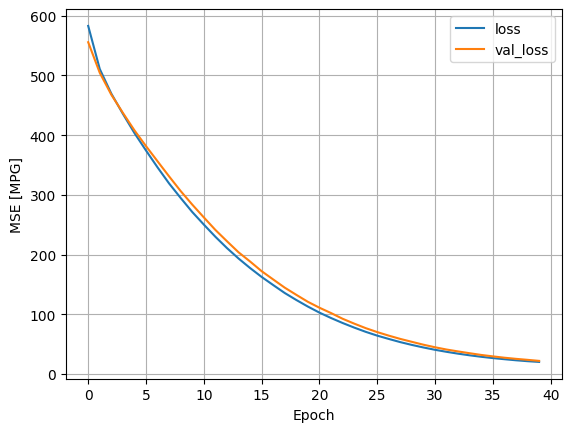

In [15]:
plot_loss(history)

In [22]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


In [23]:
print(history.history['loss'])

[582.9855346679688, 510.8402099609375, 469.6101989746094, 435.8066711425781, 403.6270446777344, 374.3907165527344, 346.06207275390625, 319.1122131347656, 294.8549499511719, 271.4116516113281, 250.36451721191406, 229.96212768554688, 211.030029296875, 193.59902954101562, 177.61044311523438, 162.69155883789062, 149.09095764160156, 135.74839782714844, 124.0683822631836, 113.0516357421875, 102.92887115478516, 93.90682220458984, 85.58644104003906, 77.90458679199219, 70.76819610595703, 64.38026428222656, 58.81983947753906, 53.494075775146484, 48.803253173828125, 44.545318603515625, 40.65936279296875, 37.258750915527344, 34.17034912109375, 31.410600662231445, 28.957698822021484, 26.78156280517578, 24.90266227722168, 23.119125366210938, 21.59743881225586, 20.367746353149414]


##### Evaluate on test data

As usual, after training we evaluate the model on unseen data.

In [16]:
test_results = model.evaluate(test_features, test_labels, verbose=1)


3/3 [==============================] - 0s 2ms/step - loss: 20.0747 - mae: 3.3650 - mse: 20.0747


##### See the effect of normalization

Remember that we can call individual keras layers as functions. Let us try to see the effect of the `Normalization()` layer on one row of features. This is one of the advantages of TF2's "Eager mode":

In [17]:
# don't use scientific notation
np.set_printoptions(suppress=True)

# note that we use 0:1 instead of 0 to make this a (1,9) tensor, and not a (9,) tensor
# the latter would not be processed correctly  by the normalizer
row = np.array(train_features)[0:1,:]
print(row)

norm_row = normalizer(row)
print(norm_row.numpy())

[[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]
[[-0.8707356  -1.0110707  -0.7853044  -1.0269395  -0.3803653  -0.51722217
  -0.46589088 -0.49601588  0.7759128 ]]


##### See the trained weights

Another aspect that we still didn't explore is how to inspect the internal weights of trained Keras layers. In this example, we have a single `Dense()` layer, which uses a $(9, 1)$ weight matrix, since it takes 9 columns as inputs and produces a single estimate as output. Let us see it.

The `.layers` field of our model contains a list of layers.

In [18]:
print(model.layers)

[<keras.layers.preprocessing.normalization.Normalization object at 0x7f88e05e1f10>, <keras.layers.core.dense.Dense object at 0x7f894f086b20>]


Each (non custom) layer has a `weights` field, which contains a list of (typically named) tensors:

In [19]:
# print(model.layers[1].weights)
print(model.layers[1].weights)

[<tf.Variable 'dense/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.07952071],
       [-0.39532503],
       [-1.8213874 ],
       [-3.4723659 ],
       [-0.9350658 ],
       [ 2.6066616 ],
       [-0.04947861],
       [ 0.48680574],
       [-0.53820544]], dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([20.405756], dtype=float32)>]


We can access each tensor values as follows:

In [20]:
print(model.layers[1].weights[0].numpy())

[[ 0.07952071]
 [-0.39532503]
 [-1.8213874 ]
 [-3.4723659 ]
 [-0.9350658 ]
 [ 2.6066616 ]
 [-0.04947861]
 [ 0.48680574]
 [-0.53820544]]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7817b2ad-42a3-441f-8072-b020be286d3c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>